<a href="https://colab.research.google.com/github/GeorgeSherif/NLP-ChatEGP/blob/main/Model%20With%20Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing & Importing the Necessary Libraries and Mounting the drive**

In [1]:
!pip3 install transformers sentencepiece protobuf torch pygal torchvision sacremoses


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 68.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.9 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=51eb6cd7265117744e3427dbdcb8181f0d1e97409e6459e7c9685049360bdda8
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremoses


In [2]:
from google.colab import drive
from IPython.display import display # Allows the use of display() for DataFrames
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
import pandas as pd
import numpy as np
import os
import warnings
import csv
import re
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
import pygal as py
import matplotlib
plt.rcParams["figure.figsize"] = (8,5)
matplotlib.rc('xtick', labelsize=7) 
matplotlib.rc('ytick', labelsize=7) 

import torch
import torchvision

from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline 

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# **Approach 1: Evaluate the English Model (BERT)**


*   English Train Data
*   Arabic Test Data
*   Train with the English Dataset
*   Translate the Arabic Dataset
*   Evaluate Model





### Load the English Dataset

In [5]:
#df = pd.read_csv('/content/gdrive/MyDrive/NLP/English Dataset.csv' ,engine="python", encoding = "ISO-8859-1")
df = pd.read_csv('/content/gdrive/MyDrive/NLP/Preprocessed.csv' ,engine="python", encoding = "ISO-8859-1")
print((df['Sentiment'] == 'neutral').sum())


2879


In [6]:
num_entries_to_remove_positive = (df['Sentiment'] == 'positive').sum() - (df['Sentiment'] == 'negative').sum()
num_entries_to_remove_neutral = (df['Sentiment'] == 'neutral').sum() - (df['Sentiment'] == 'negative').sum()
print(num_entries_to_remove_neutral)


indices_to_remove = df[df['Sentiment'] == 'positive'].sample(num_entries_to_remove_positive).index
dfPositive = df[df['Sentiment'] == 'positive'].drop(indices_to_remove)

indices_to_remove = df[df['Sentiment'] == 'neutral'].sample(num_entries_to_remove_neutral).index
dfNeutral = df[df['Sentiment'] == 'neutral'].drop(indices_to_remove)

indices_to_remove = df[df['Sentiment'] == 'negative'].sample(0).index
dfNegative = df[df['Sentiment'] == 'negative'].drop(indices_to_remove)

print(dfNegative)

2275
     Sentiment                                           Sentence
2     negative    The international electronic industry compan...
415   negative    A tinyurl link takes users scamming site pro...
421   negative    Compared FTSE 100 index rose 36.7 points ( 0...
423   negative    Compared FTSE 100 index rose 94.9 points ( 1...
500   negative    One challenges oil production North Sea scal...
...        ...                                                ...
4840  negative    HELSINKI Thomson Financial - Shares Cargotec...
4841  negative    LONDON MarketWatch -- Share prices ended low...
4843  negative    Operating profit fell EUR 35.4 mn EUR 68.8 m...
4844  negative    Net sales Paper segment decreased EUR 221.6 ...
4845  negative    Sales Finland decreased 10.5 % January sales...

[604 rows x 2 columns]


In [7]:
dfNew = pd.concat((dfNegative, dfNeutral, dfPositive), axis = 0)
dfNew
df = dfNew

In [8]:
df['Sentiment'] = df['Sentiment'].replace(['negative','neutral','positive'],[0,1,2])
df

,Sentiment,Sentence
2,0,The international electronic industry compan...
415,0,A tinyurl link takes users scamming site pro...
421,0,Compared FTSE 100 index rose 36.7 points ( 0...
423,0,Compared FTSE 100 index rose 94.9 points ( 1...
500,0,One challenges oil production North Sea scal...
...,...,...
4575,2,As part transaction M-real Sappi also signed...
4592,2,In fourth quarter 2009 Atria 's net loss shr...
4773,2,According company operating profit excluding...
4787,2,Our superior customer centricity expertise d...


<Axes: xlabel='count', ylabel='Sentiment'>

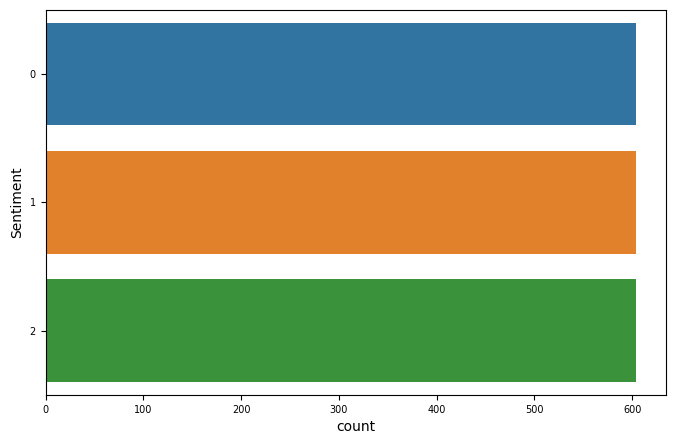

In [9]:
sns.countplot(y="Sentiment",data=df)

In [10]:
df.drop_duplicates(subset=['Sentence'],keep='first',inplace=True)
df

,Sentiment,Sentence
2,0,The international electronic industry compan...
415,0,A tinyurl link takes users scamming site pro...
421,0,Compared FTSE 100 index rose 36.7 points ( 0...
423,0,Compared FTSE 100 index rose 94.9 points ( 1...
500,0,One challenges oil production North Sea scal...
...,...,...
4575,2,As part transaction M-real Sappi also signed...
4592,2,In fourth quarter 2009 Atria 's net loss shr...
4773,2,According company operating profit excluding...
4787,2,Our superior customer centricity expertise d...


### Sentiment Analysis using BERT

In [11]:
from sklearn.model_selection import train_test_split
X_features = df["Sentence"]
Y_features = df["Sentiment"]
X_train, X_val, y_train, y_val = train_test_split(df.index.values, df.Sentiment.values, test_size=0.2, random_state=42, shuffle=True)

In [12]:
from transformers import BertTokenizer,BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = 3,
                                                      id2label={0: 'negative', 1: 'neutral', 2: 'positive'},
                                                      output_attentions = False,
                                                      output_hidden_states = False).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [13]:
df['data_type'] = ['not_set'] * df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

#groupby count
df.groupby([ 'Sentiment', 'data_type']).count()
#df = df.rename(columns={'Review Text': 'Sentence'})
df[df.data_type == 'train'].Sentence.values


array(['  The international electronic industry company Elcoteq laid tens employees Tallinn facility contrary earlier layoffs company contracted ranks office workers daily Postimees reported',
       '  A tinyurl link takes users scamming site promising users earn thousands dollars becoming Google ( NASDAQ GOOG ) Cash advertiser',
       '  Compared FTSE 100 index rose 36.7 points ( 0.6 % ) day relative price change -0.2 %',
       ...,
       "  In fourth quarter 2009 Atria 's net loss shrank EUR 1.2 million EUR 5.9 million net sales contracted EUR 340.4 million EUR 361.1 million",
       '  According company operating profit excluding non-recurring items fourth quarter 2009 significantly better expected also better figures fourth quarter 2008',
       '  The 2015 target net sales set EUR 1bn target return investment 20 %'],
      dtype=object)

In [14]:
#encode train set
encoded_data_train = tokenizer.batch_encode_plus(df[df.data_type == 'train'].Sentence.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                truncation=True,
                                                return_tensors = 'pt')
                                                
#encode validation set
encoded_data_val = tokenizer.batch_encode_plus( df[df.data_type == 'val'].Sentence.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                truncation=True,
                                                return_tensors = 'pt')

In [15]:
#train set
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].Sentiment.values)

#validation set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type == 'val'].Sentiment.values)
     

In [16]:
from torch.utils.data import TensorDataset

#train set
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

#validation set
dataset_val = TensorDataset(input_ids_val, 
                             attention_masks_val, 
                             labels_val)

In [17]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 8

#train set
dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

#validation set
dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = batch_size) #since we don't have to do backpropagation for this step

In [18]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-7) #2e-5 > 5e-5
                 
epochs = 16

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps =len(dataloader_train)*epochs)


In [19]:
def evaluate(dataloader_val):

    #evaluation mode 
    model.eval()
    
    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        #load into GPU
        batch = tuple(b.to(device) for b in batch)
        
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [20]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [21]:
#accuracy score
def accuracy_per_class(preds, labels):
    #label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    #make prediction
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    correct = 0
    total = 0

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        #print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n -> {len(y_preds[y_preds==label]) / len(y_true)}')
        correct = correct + len(y_preds[y_preds==label])
        total = total + len(y_true)
    return correct / total

In [22]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [23]:
epochs_accuracies = []

In [24]:
from tqdm import tqdm

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc = 'Epoch {:1d}'.format(epoch), 
                        leave = False, 
                        disable = False)
    
    for batch in progress_bar:
        
        model.zero_grad() #set gradient to 0
    
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids': batch[0], 
                  'attention_mask': batch[1], 
                  'labels': batch[2]}
        
        outputs = model(**inputs) #unpack the dict straight into inputs
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
        
    torch.save(model.state_dict(), f'/content/gdrive/MyDrive/NLP/BERT_ft_epoch{epoch}.model')
    
    tqdm.write('\n Epoch {epoch}')
    
    loss_train_ave = loss_train_total / len(dataloader_train)
    tqdm.write('Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    true_vals.shape
    accuracy = accuracy_per_class(predictions, true_vals)
    epochs_accuracies.append(accuracy)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')
    tqdm.write(f'Accuracy Score: {accuracy}')

  0%|          | 0/16 [00:47<?, ?it/s]


 Epoch {epoch}
Training loss: {loss_train_avg}



  6%|▋         | 1/16 [00:51<12:47, 51.16s/it]

Accuracy:102/130
 -> 0.7846153846153846
Accuracy:84/110
 -> 0.7636363636363637
Accuracy:85/122
 -> 0.6967213114754098
Validation loss: 0.6609092264071755
F1 Score (weighted): 0.7500602435255762
Accuracy Score: 0.7486187845303868



  6%|▋         | 1/16 [01:39<12:47, 51.16s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 12%|█▎        | 2/16 [01:42<12:01, 51.50s/it]

Accuracy:113/130
 -> 0.8692307692307693
Accuracy:67/110
 -> 0.6090909090909091
Accuracy:94/122
 -> 0.7704918032786885
Validation loss: 0.5474269488907378
F1 Score (weighted): 0.7540867321647963
Accuracy Score: 0.7569060773480663



 12%|█▎        | 2/16 [02:31<12:01, 51.50s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 19%|█▉        | 3/16 [02:34<11:12, 51.73s/it]

Accuracy:115/130
 -> 0.8846153846153846
Accuracy:82/110
 -> 0.7454545454545455
Accuracy:91/122
 -> 0.7459016393442623
Validation loss: 0.5743254181402533
F1 Score (weighted): 0.7943548973148291
Accuracy Score: 0.7955801104972375



 19%|█▉        | 3/16 [03:24<11:12, 51.73s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 25%|██▌       | 4/16 [03:27<10:25, 52.14s/it]

Accuracy:110/130
 -> 0.8461538461538461
Accuracy:80/110
 -> 0.7272727272727273
Accuracy:100/122
 -> 0.819672131147541
Validation loss: 0.7078950246998473
F1 Score (weighted): 0.8013865116584987
Accuracy Score: 0.8011049723756906



 25%|██▌       | 4/16 [04:16<10:25, 52.14s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 31%|███▏      | 5/16 [04:19<09:33, 52.10s/it]

Accuracy:113/130
 -> 0.8692307692307693
Accuracy:76/110
 -> 0.6909090909090909
Accuracy:94/122
 -> 0.7704918032786885
Validation loss: 0.9196065997239202
F1 Score (weighted): 0.7809699578223744
Accuracy Score: 0.7817679558011049



 31%|███▏      | 5/16 [05:11<09:33, 52.10s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 38%|███▊      | 6/16 [05:14<08:49, 52.97s/it]

Accuracy:110/130
 -> 0.8461538461538461
Accuracy:83/110
 -> 0.7545454545454545
Accuracy:98/122
 -> 0.8032786885245902
Validation loss: 0.9216364358663154
F1 Score (weighted): 0.8043171727907028
Accuracy Score: 0.8038674033149171



 38%|███▊      | 6/16 [06:01<08:49, 52.97s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 44%|████▍     | 7/16 [06:04<07:49, 52.19s/it]

Accuracy:115/130
 -> 0.8846153846153846
Accuracy:85/110
 -> 0.7727272727272727
Accuracy:96/122
 -> 0.7868852459016393
Validation loss: 0.9738700852638272
F1 Score (weighted): 0.8171462233847839
Accuracy Score: 0.8176795580110497



 44%|████▍     | 7/16 [06:54<07:49, 52.19s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 50%|█████     | 8/16 [06:57<06:58, 52.27s/it]

Accuracy:115/130
 -> 0.8846153846153846
Accuracy:86/110
 -> 0.7818181818181819
Accuracy:93/122
 -> 0.7622950819672131
Validation loss: 1.026105268116858
F1 Score (weighted): 0.8115273003955034
Accuracy Score: 0.8121546961325967



 50%|█████     | 8/16 [07:43<06:58, 52.27s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 56%|█████▋    | 9/16 [07:47<06:00, 51.51s/it]

Accuracy:113/130
 -> 0.8692307692307693
Accuracy:84/110
 -> 0.7636363636363637
Accuracy:97/122
 -> 0.7950819672131147
Validation loss: 1.0524763103205022
F1 Score (weighted): 0.8122764028375425
Accuracy Score: 0.8121546961325967



 56%|█████▋    | 9/16 [08:31<06:00, 51.51s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 62%|██████▎   | 10/16 [08:34<05:01, 50.28s/it]

Accuracy:112/130
 -> 0.8615384615384616
Accuracy:77/110
 -> 0.7
Accuracy:104/122
 -> 0.8524590163934426
Validation loss: 1.2224297217174394
F1 Score (weighted): 0.8086620721728245
Accuracy Score: 0.8093922651933702



 62%|██████▎   | 10/16 [09:17<05:01, 50.28s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 69%|██████▉   | 11/16 [09:21<04:05, 49.11s/it]

Accuracy:114/130
 -> 0.8769230769230769
Accuracy:79/110
 -> 0.7181818181818181
Accuracy:100/122
 -> 0.819672131147541
Validation loss: 1.1408770028565018
F1 Score (weighted): 0.8088596276472398
Accuracy Score: 0.8093922651933702



 69%|██████▉   | 11/16 [10:04<04:05, 49.11s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 75%|███████▌  | 12/16 [10:07<03:13, 48.29s/it]

Accuracy:109/130
 -> 0.8384615384615385
Accuracy:79/110
 -> 0.7181818181818181
Accuracy:102/122
 -> 0.8360655737704918
Validation loss: 1.1322964491783236
F1 Score (weighted): 0.8016703903082775
Accuracy Score: 0.8011049723756906



 75%|███████▌  | 12/16 [10:51<03:13, 48.29s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 81%|████████▏ | 13/16 [10:54<02:23, 47.86s/it]

Accuracy:113/130
 -> 0.8692307692307693
Accuracy:76/110
 -> 0.6909090909090909
Accuracy:102/122
 -> 0.8360655737704918
Validation loss: 1.2282470683162303
F1 Score (weighted): 0.8030266543514706
Accuracy Score: 0.8038674033149171



 81%|████████▏ | 13/16 [11:38<02:23, 47.86s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 88%|████████▊ | 14/16 [11:41<01:35, 47.63s/it]

Accuracy:113/130
 -> 0.8692307692307693
Accuracy:76/110
 -> 0.6909090909090909
Accuracy:102/122
 -> 0.8360655737704918
Validation loss: 1.3103359955066876
F1 Score (weighted): 0.8030266543514706
Accuracy Score: 0.8038674033149171



 88%|████████▊ | 14/16 [12:25<01:35, 47.63s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 94%|█████████▍| 15/16 [12:28<00:47, 47.47s/it]

Accuracy:112/130
 -> 0.8615384615384616
Accuracy:77/110
 -> 0.7
Accuracy:102/122
 -> 0.8360655737704918
Validation loss: 1.2811839919165282
F1 Score (weighted): 0.8035167809577767
Accuracy Score: 0.8038674033149171



 94%|█████████▍| 15/16 [13:11<00:47, 47.47s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



100%|██████████| 16/16 [13:15<00:00, 49.70s/it]

Accuracy:112/130
 -> 0.8615384615384616
Accuracy:78/110
 -> 0.7090909090909091
Accuracy:102/122
 -> 0.8360655737704918
Validation loss: 1.2164118707011726
F1 Score (weighted): 0.8062509017366853
Accuracy Score: 0.8066298342541437


In [25]:
_, predictions, true_vals = evaluate(dataloader_val)

100%|██████████| 46/46 [00:03<00:00, 14.45it/s]


In [26]:
true_vals.shape
accuracy_per_class(predictions, true_vals)

Accuracy:112/130
 -> 0.8615384615384616
Accuracy:78/110
 -> 0.7090909090909091
Accuracy:102/122
 -> 0.8360655737704918


0.8066298342541437

In [34]:
epochs_accuracies
epochs_accuracies2 = []
for i in range(len(epochs_accuracies)):
  epochs_accuracies2.append(float(round(epochs_accuracies[i] * 100, 1)))
epochs_accuracies2

[74.9,
 75.7,
 79.6,
 80.1,
 78.2,
 80.4,
 81.8,
 81.2,
 81.2,
 80.9,
 80.9,
 80.1,
 80.4,
 80.4,
 80.4,
 80.7]